# `fastprop` on AqSolDBc and OChemCurated
This notebook demonstrates using `fastprop` to train on the AqSolDBc dataset described in [Will we ever be able to accurately predict solubility?](https://doi.org/10.1038/s41597-024-03105-6) and then test on OChemCurated set from the same.
These datasets are made available under the terms of the [Open License 2.0](https://www.etalab.gouv.fr/wp-content/uploads/2018/11/open-licence.pdf) - you may download the original data from https://entrepot.recherche.data.gouv.fr/dataset.xhtml?persistentId=doi:10.57745/CZVZIA.

Be sure to use a GPU runtime on Google Colab to speed up the training!

*Note:*
As of June 21, 2024 the datasets at the listed link are slightly out-of-date.
The most recent and correct versions, graciously provided by the corresponding author, have been included in this repository and will be available at the above link in the future.


# Part 0: Installing `fastprop`
Adapted from the installation instructions at the [fastprop GitHub repository](https://github.com/JacksonBurns/fastprop):

In [1]:
%pip install 'fastprop>=1.0.6'

  Using cached fastprop-1.0.6-py3-none-any.whl.metadata (14 kB)
Using cached fastprop-1.0.6-py3-none-any.whl (31 kB)
  Attempting uninstall: fastprop
    Found existing installation: fastprop 0.0.0b0
    Uninstalling fastprop-0.0.0b0:
      Successfully uninstalled fastprop-0.0.0b0
Note: you may need to restart the kernel to use updated packages.


## Part 1: Train `fastprop` on AqSolDBc
Let's look at the data on which we will be fitting:

In [2]:
!head -n 2 data/AqSolDBc.csv

Source,ID,Name,SMILES,SmilesCurated,ExperimentalLogS,InChI,InChIKey,Composition,Origin,Dataset,HasError,ErrorType,AtomCount,AlertAtoms,DuplicateGroup,DuplicateSD,DuplicateOccurrence,SD
AqSolDBc,A-5,4-chlorobenzaldehyde,Clc1ccc(C=O)cc1,ClC1=CC=C(C=O)C=C1,-2.1770779444,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,mono-constituent,organic,A,No,,9,False,None,0.0,1,0.0


We have columns for the SMILES representation of each molecule (`SmilesCurated`), the solubility (`ExperimentalLogS`), and a number of metadata columns.

To train `fastprop` on this dataset, we use the following configuration file:

In [3]:
!cat train_config.yml

# train_config.yml
# usage: fastprop train train_config.yml
#
# This file contains the model settings to perform training
# on the Llompart curated AqSolDBc dataset.
#
# The data can be downloaded from the repository given in the
# corresponding paper:
# https://entrepot.recherche.data.gouv.fr/dataset.xhtml?persistentId=doi:10.57745/CZVZIA
#
# Multiple models were benchmarked in that reference study, achieving best-case performance
# of 0.56 R2 and 1.74 MSE (1.32 RMSE) on OChem-Curated


# generic args
output_directory: output
random_seed: 1701
problem_type: regression

# featurization
input_file: data/AqSolDBc.csv
target_columns: ExperimentalLogS
smiles_column: SmilesCurated
descriptor_set: all

# architecture - from optimization
hidden_size: 2000
fnn_layers: 3
clamp_input: True

# training
number_repeats: 10
number_epochs: 100
batch_size: 1024
patience: 15
train_size: 0.8
val_size: 0.1
test_size: 0.1
sampler: random


The reference study uses 10-fold cross validation, which we mimic here with 10 random repetitions.
The data is split according to a typical 80:10:10 training:validation:testing setup.

Two interesting details about the architecture:
 - after hyperparameter optimization, the ideal architecture was 3 hidden layers (`fnn_layers`) and a `hidden_size` of 2000, pretty close to the defaults of 2 and 1800
 - `clamp_input` was set to `True` - this limits the range of the inputs to +/-3 which for our normally-scaled descriptors means 3-sigma allowance for variation. This aids in extrapolation!

Let's start the training!
The first execution will have a few minutes of downtime while `fastprop` calculates all of the descriptors, but for subsequent runs they will be saved, speeding up training.

In [4]:
!fastprop train train_config.yml

Seed set to 1701
[06/24/2024 11:24:33 AM fastprop.descriptors] INFO: Calculating descriptors
100%|███████████████████████████████████████| 8047/8047 [08:23<00:00, 15.97it/s]
[06/24/2024 11:33:00 AM fastprop.descriptors] INFO: Descriptor calculation complete, elapsed time: 0:08:26.439630
[06/24/2024 11:33:11 AM fastprop.descriptors] INFO: Cached descriptors to output/cached_AqSolDBc_all_1719237963.csv
[06/24/2024 11:33:11 AM fastprop.cli.train] INFO: Run 'tensorboard --logdir output/fastprop_1719257073/tensorboard_logs' to track training progress.
[06/24/2024 11:33:11 AM fastprop.cli.train] INFO: Training model 1 of 10 (random_seed=1701)
[06/24/2024 11:33:11 AM fastprop.cli.train] INFO: Model architecture:
{fastprop(
  (fnn): Sequential(
    (clamp): ClampN(n=3)
    (lin1): Linear(in_features=1613, out_features=2000, bias=True)
    (act1): ReLU()
    (lin2): Linear(in_features=2000, out_features=2000, bias=True)
    (act2): ReLU()
    (lin3): Linear(in_features=2000, out_features=2000, 

Our training progress has been saved to the directory `output`, which we can look at with `tree`:

In [5]:
!tree -I __pycache__ 

.
├── data
│   ├── AqSolDBc.csv
│   ├── LICENSE
│   └── OChem_Clean.csv
├── fastprop_llompart.ipynb
├── LICENSE
├── output
│   ├── cached_AqSolDBc_all_1719237963.csv
│   └── fastprop_1719257073
│       ├── checkpoints
│       │   ├── repetition-10-epoch=18-val_loss=0.00.ckpt
│       │   ├── repetition-1-epoch=39-val_loss=0.00.ckpt
│       │   ├── repetition-2-epoch=16-val_loss=0.00.ckpt
│       │   ├── repetition-3-epoch=22-val_loss=0.00.ckpt
│       │   ├── repetition-4-epoch=25-val_loss=0.00.ckpt
│       │   ├── repetition-5-epoch=19-val_loss=0.00.ckpt
│       │   ├── repetition-6-epoch=22-val_loss=0.00.ckpt
│       │   ├── repetition-7-epoch=12-val_loss=0.00.ckpt
│       │   ├── repetition-8-epoch=14-val_loss=0.00.ckpt
│       │   └── repetition-9-epoch=19-val_loss=0.00.ckpt
│       ├── fastprop_log.txt
│       └── tensorboard_logs
│           ├── repetition_1
│           │   ├── events.out.tfevents.1719243193.jackson-Precision-7540.179813.0
│           │   ├── events.out.tfevents.1

We see the log file for the entire run, as well as the checkpoints for training/prediction and the tensorboard logs for each of the ten replicates. The cached descriptors are also saved with with a timestamp tracking when the source file was modified, ensuring that we don't accidentally re-use out-of-date descriptors.

# Part 2: Predict on `OChemCurated.csv`
The dataset `OChemCurated` includes some rows that overlap with `AqSolDBc` - let's remove those, and rename the headers while we are at it:

In [6]:
!echo -e "smiles,logS\n" "$(grep New data/OChem_Clean.csv | awk -F, '{print $2, $3}' OFS=,)" > ochem_test.csv

Taking a look at this file, it's in basically the same format as the training data:

In [7]:
!cat ochem_test.csv

smiles,logS
 NC(=[NH2+])N[N+]([O-])=O,-1.37
CCC1(CC)C(=O)NC(=O)NC1=O,-1.39
[O-]C(=O)c1ccccc1,-1.55
CCCCC(=O)CC(C)=O,-1.56
CC(C)CC(=O)CC(C)=O,-1.6
Oc1ccccc1C([O-])=O,-1.82
CCCC(CCC)C([O-])=O,-1.86
COc1ccc2CCC34C=CC(=O)CC3(CC[NH+]4C)c2c1O,-1.87
[O-]C(=O)CCCCCCCC([O-])=O,-1.89
CCc1nnc([N-]S(=O)(=O)c2ccc(N)cc2)s1,-1.94
Nc1ccccc1[N+]([O-])=O,-1.96
[O-]C(=O)c1ccccc1C([O-])=O,-2.11
CC(=O)Nc1ccccc1O,-2.24
[O-][N+](=O)[C-]1C(=O)NC(=O)[N-]C1=O,-2.28
COC(=O)c1ccccc1O,-2.34
CCOC(=O)c1ccc(O)cc1,-2.35
Cc1nnc([N-]S(=O)(=O)c2ccc(N)cc2)s1,-2.41
C[NH+](C)C1C2CC3C(O)c4c(Cl)ccc(O)c4C(=O)C3=C(O)C2(O)C(=O)C(C(N)=O)=C1[O-],-2.52
Oc1cccc2ncccc12,-2.54
CCCCCCCCC([O-])=O,-2.75
CN1C(=O)ON(C1=O)c1ccc(Cl)c(Cl)c1,-2.82
Cc1ccnc([N-]S(=O)(=O)c2ccc(N)cc2)n1,-2.85
CC1C2C(O)C3C([NH+](C)C)C([O-])=C(C(N)=O)C(=O)C3(O)C(O)=C2C(=O)c2c(O)cccc12,-2.87
C[NH+](C)C1C2CC3C(=C(O)C2(O)C(=O)C(C(N)=O)=C1[O-])C(=O)c1c(O)ccc(Cl)c1C3(C)O,-2.88
Cc1noc([N-]S(=O)(=O)c2ccc(N)cc2)c1C,-2.91
[O-]C(=O)CCl,0.93
OC1=C(Oc2cc([O-])cc(O)c2C1=O)c1ccc(

Now `fastprop predict` can either calculate the input descriptors on its own when called, or we can calculate them ourselves and pass them in manually.
We'll do the latter here to demonstrate how.

First we write the SMILES strings for the dataset into a separate file (one of the quirks of the underlying `mordred` package) then we calculate the descriptors, writing the output into a file:

In [8]:
! awk -F, 'NR>1 {print $1}' ochem_test.csv > ochem_smiles.smi && python -m mordred -t smi -o ochem_test_descriptors.csv ochem_smiles.smi

100%|███████████████████████████████████████| 2063/2063 [00:54<00:00, 37.84it/s]


And now we can freely pass these to `fastprop` - the nested command (inside the `$()`) just picks the most recent run, feel free to substitute this with a specific result, if you like!

Note that we are also saving the results to a csv file called `ochem_pred.csv`.
This prevents us having to run these predictions again, and allows for easy post-processing in your software of choice.

In [9]:
!fastprop predict --output ochem_pred.csv --precomputed-descriptors ochem_test_descriptors.csv $(ls -d output/fastprop_*/checkpoints | sort -Vr | head -n 1) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|█████████████████| 17/17 [00:00<00:00, 159.86it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|█████████████████| 17/17 [00:00<00:00, 569.36it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|█████████████████| 17/17 [00:00<00:00, 559.63it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|█████████████████| 17/17 [00:00<00:00, 571.68it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|█████████████████| 17/17 [00:00<00:00, 569.40it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|█████████████████| 17/17 [00:00<00:00, 558.59it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|█████████████████| 17/17 [00:00<00:00,

If we wanted to just stream the predictions (i.e. not actually save anything to the disk), we could do:

```fastprop predict -o out.csv checkpoint_dir --descriptor-set all --smiles-file <(awk -F, 'NR>1 {print $1}' ochem_test.csv)```

which would just read all of the SMILES strings in the test data file and send them to `fastprop`.

Finally, let's generate a parity plot in the same style of the source paper to show our results!

The code for this is a lot of tedious `matplotlib` manipulation - if you are curious, check out the `parity_plot.py` file.
Otherwise, just take a look at the results below!

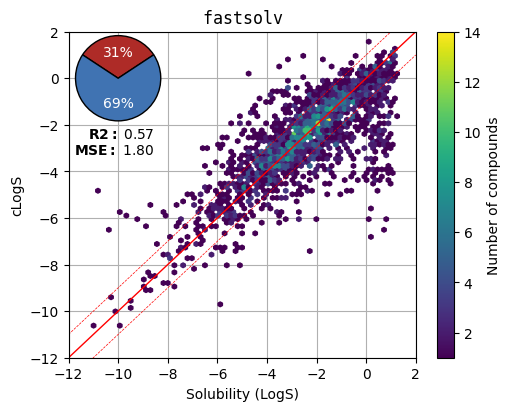

In [10]:
from parity_plot import parity_plot


parity_plot(truth="ochem_test.csv", prediction="ochem_pred.csv")

This is nearly the same performance as the AqSolPred model reported in the source paper, their best result!
It's also better than Chemprop, with (hopefully) a similar level of user-friendliness.

Perhaps more impressive is the simplicity of the `fastprop` model - the alternative is actually three models working together, whereas this `fastprop` model is a single MLP.
Turns out molecular descriptors alone _are_ sufficient, we just need enough of them!

Found any issues with this notebook, have any questions about `fastprop`, or have any suggestions to make either better?
Open an issue on this notebook's GitHub page: [github.com/JacksonBurns/fastprop_llompart](https://github.com/JacksonBurns/fastprop_llompart)